#### AirBNB - Broward County
Evaluating AirBNB data for Broward County, Florida

In [327]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

df = pd.read_csv('./listings.csv.gz', compression='gzip', header=0, sep=',')

C:\Users\ronda\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [328]:
# Examine the data
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,42084,https://www.airbnb.com/rooms/42084,20200618045720,2020-06-18,Oceanview luxury hotel suite,Luxury property located in the heart of the Ft...,All the comforts of home and a glorious ocean ...,Luxury property located in the heart of the Ft...,none,Can't beat the location. The Fort Lauderdale B...,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,1.04
1,57818,https://www.airbnb.com/rooms/57818,20200618045720,2020-06-18,PRIVATE HOUSE NEAR BEACH SLEEP 5,Beautifully private duplex that allows you to ...,Peaceful house on Nature Preserve Close to eve...,Beautifully private duplex that allows you to ...,none,"This is a family oriented, quiet, peaceful nei...",...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.45
2,69824,https://www.airbnb.com/rooms/69824,20200618045720,2020-06-18,2 bd/2ba Oceanfront Condo,NaN,Beautiful and meticulous 2 master suite luxury...,Beautiful and meticulous 2 master suite luxury...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.23
3,83449,https://www.airbnb.com/rooms/83449,20200618045720,2020-06-18,MARY POP APTS 2/1 APT SLEEP 5,MARY POP APARTMENTS 1&2 BEDROOM SUITES ACCOMMO...,NOTE: WE ARE HERE TO HELP YOU . TEMPORARY ACCO...,MARY POP APARTMENTS 1&2 BEDROOM SUITES ACCOMMO...,none,NaN,...,f,f,strict_14_with_grace_period,t,t,9,8,1,0,0.19
4,105411,https://www.airbnb.com/rooms/105411,20200618045720,2020-06-18,House in the Ranches,Close to Cleveland Clinic Hospital and mayor h...,"Great location, close to most highways in the ...",Close to Cleveland Clinic Hospital and mayor h...,none,"Very close to I75, one of the main highways. Y...",...,f,f,moderate,f,f,1,1,0,0,0.05


In [329]:
df.shape

(10858, 106)

In [330]:
# Drop columns with 0 or 1 unique values (all null or all the same)
df_clean = df
for col in df.columns:
    if df[col].nunique() <= 1:
        try:
            df_clean = df_clean.drop(col, axis=1)
        except:
            continue

In [331]:
# Convert prices to float
curr_cols = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
for col in curr_cols:
    try: 
        df_clean[col] = df_clean[col].replace('[\$,]', '', regex=True).astype(float)
    except:
        continue

In [332]:
# Evaluate columns with nulls and remove columns that are mostly null. 
# There do not appear to be any high null count columns that we should retain to reduce loss of information.
# Many columns with high null values are text descriptions which are difficult to quantify. 
# weekly_price and monthly_price are mostly null, but we can look at price instead as it is complete.
# It would be interesting to look at square_feet, but there are only 31 values available out of 10839.
# neighbourhood was previously cleaned and values were added to neighbourhood_cleansed.
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10858 entries, 0 to 10857
Data columns (total 96 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            10858 non-null  int64  
 1   listing_url                                   10858 non-null  object 
 2   name                                          10857 non-null  object 
 3   summary                                       10282 non-null  object 
 4   space                                         8102 non-null   object 
 5   description                                   10499 non-null  object 
 6   neighborhood_overview                         7300 non-null   object 
 7   notes                                         5274 non-null   object 
 8   transit                                       5892 non-null   object 
 9   access                                        6013 non-null  

In [333]:
# Drop columns with more than 50% null
df_clean = df_clean.drop(set(df_clean[df_clean.columns[df_clean.isnull().mean() > 0.5]]), axis=1)

In [334]:
df_clean.head()

,id,listing_url,name,summary,space,description,neighborhood_overview,transit,access,interaction,...,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,42084,https://www.airbnb.com/rooms/42084,Oceanview luxury hotel suite,Luxury property located in the heart of the Ft...,All the comforts of home and a glorious ocean ...,Luxury property located in the heart of the Ft...,Can't beat the location. The Fort Lauderdale B...,The Hotel offers valet parking for $39.00 per ...,"Guests also receive access to the Hotel Pool, ...",NaN,...,"{""Florida State"","" Broward County"","" FL""}",f,strict_14_with_grace_period,f,f,1,1,0,0,1.04
1,57818,https://www.airbnb.com/rooms/57818,PRIVATE HOUSE NEAR BEACH SLEEP 5,Beautifully private duplex that allows you to ...,Peaceful house on Nature Preserve Close to eve...,Beautifully private duplex that allows you to ...,"This is a family oriented, quiet, peaceful nei...",Please park in the driveway. Other tennants p...,There is a washer and dryer in the laundry roo...,"I can leave you with your privacy, or if you n...",...,"{""Florida State"","" Broward County"","" FL""}",f,strict_14_with_grace_period,f,f,1,1,0,0,0.45
2,69824,https://www.airbnb.com/rooms/69824,2 bd/2ba Oceanfront Condo,NaN,Beautiful and meticulous 2 master suite luxury...,Beautiful and meticulous 2 master suite luxury...,NaN,NaN,NaN,NaN,...,"{""Florida State"","" Broward County"","" FL""}",f,strict_14_with_grace_period,f,f,1,1,0,0,0.23
3,83449,https://www.airbnb.com/rooms/83449,MARY POP APTS 2/1 APT SLEEP 5,MARY POP APARTMENTS 1&2 BEDROOM SUITES ACCOMMO...,NOTE: WE ARE HERE TO HELP YOU . TEMPORARY ACCO...,MARY POP APARTMENTS 1&2 BEDROOM SUITES ACCOMMO...,NaN,NaN,NaN,NaN,...,"{""Florida State"","" Broward County"","" FL""}",f,strict_14_with_grace_period,t,t,9,8,1,0,0.19
4,105411,https://www.airbnb.com/rooms/105411,House in the Ranches,Close to Cleveland Clinic Hospital and mayor h...,"Great location, close to most highways in the ...",Close to Cleveland Clinic Hospital and mayor h...,"Very close to I75, one of the main highways. Y...",There is no public transportation,You will have access to the entire property.,NaN,...,"{""Florida State"","" Broward County"","" FL""}",f,moderate,f,f,1,1,0,0,0.05


In [335]:
# Remove columns with free text descriptions, urls, redundant data, and other data that does not provide much information
text_cols = ['listing_url', 'name', 'summary', 'space', 'description', 'host_location', 'host_since', 'neighborhood_overview', 'transit', 'access', 'interaction', 'house_rules', 'picture_url', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'market', 'street', 'city', 'state', 'smart_location', 'country_code', 'country', 'zipcode', 'latitude', 'longitude', 'is_location_exact', 'amenities', 'minimum_minimum_nights', 'minimum_maximum_nights', 'maximum_minimum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'first_review', 'last_review','number_of_reviews_ltm', 'requires_license', 'jurisdiction_names', 'require_guest_profile_picture', 'require_guest_phone_verification'
]
for col in text_cols:
    try:
        df_clean = df_clean.drop(col, axis=1)
    except:
        continue
df_clean.head()

,id,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,property_type,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,42084,183960,NaN,NaN,NaN,f,1.0,f,Fort Lauderdale,Apartment,...,10.0,10.0,9.0,f,strict_14_with_grace_period,1,1,0,0,1.04
1,57818,275948,NaN,NaN,50%,f,1.0,f,Hollywood,House,...,10.0,10.0,9.0,f,strict_14_with_grace_period,1,1,0,0,0.45
2,69824,351303,within an hour,100%,60%,f,2.0,t,Hallandale Beach,Apartment,...,NaN,NaN,NaN,f,strict_14_with_grace_period,1,1,0,0,0.23
3,83449,454736,within a day,100%,100%,f,8.0,f,Dania Beach,Apartment,...,10.0,10.0,10.0,f,strict_14_with_grace_period,9,8,1,0,0.19
4,105411,532930,within an hour,80%,11%,f,3.0,t,Southwest Ranches,House,...,10.0,9.0,10.0,f,moderate,1,1,0,0,0.05


In [336]:
# Convert percentages to float
percent_cols = ['host_response_rate', 'host_acceptance_rate']
for col in percent_cols:
    try: 
        df_clean[col] = df_clean[col].replace('[\%,]', '', regex=True).astype(float) / 100
    except:
        continue
df_clean.head()

,id,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,property_type,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,42084,183960,NaN,NaN,NaN,f,1.0,f,Fort Lauderdale,Apartment,...,10.0,10.0,9.0,f,strict_14_with_grace_period,1,1,0,0,1.04
1,57818,275948,NaN,NaN,0.50,f,1.0,f,Hollywood,House,...,10.0,10.0,9.0,f,strict_14_with_grace_period,1,1,0,0,0.45
2,69824,351303,within an hour,1.0,0.60,f,2.0,t,Hallandale Beach,Apartment,...,NaN,NaN,NaN,f,strict_14_with_grace_period,1,1,0,0,0.23
3,83449,454736,within a day,1.0,1.00,f,8.0,f,Dania Beach,Apartment,...,10.0,10.0,10.0,f,strict_14_with_grace_period,9,8,1,0,0.19
4,105411,532930,within an hour,0.8,0.11,f,3.0,t,Southwest Ranches,House,...,10.0,9.0,10.0,f,moderate,1,1,0,0,0.05


In [337]:
# Convert True/False values to 1/0
t_f_cols = ['host_identity_verified','host_is_superhost','instant_bookable']
for col in t_f_cols:
    try: 
        df_clean[col] = df_clean[col].replace({'t': 1, 'f': 0})
    except:
        continue

In [338]:
df_clean.head()

,id,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,property_type,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,42084,183960,NaN,NaN,NaN,0.0,1.0,0.0,Fort Lauderdale,Apartment,...,10.0,10.0,9.0,0,strict_14_with_grace_period,1,1,0,0,1.04
1,57818,275948,NaN,NaN,0.50,0.0,1.0,0.0,Hollywood,House,...,10.0,10.0,9.0,0,strict_14_with_grace_period,1,1,0,0,0.45
2,69824,351303,within an hour,1.0,0.60,0.0,2.0,1.0,Hallandale Beach,Apartment,...,NaN,NaN,NaN,0,strict_14_with_grace_period,1,1,0,0,0.23
3,83449,454736,within a day,1.0,1.00,0.0,8.0,0.0,Dania Beach,Apartment,...,10.0,10.0,10.0,0,strict_14_with_grace_period,9,8,1,0,0.19
4,105411,532930,within an hour,0.8,0.11,0.0,3.0,1.0,Southwest Ranches,House,...,10.0,9.0,10.0,0,moderate,1,1,0,0,0.05


In [339]:
# Convert ordinal string values
values = {'within an hour': 1, 'within a few hours': 2, 'within a day': 3, 'a few days or more': 4, 'flexible': 1, 'moderate': 2, 'strict_14_with_grace_period': 3, 'super_strict_30': 4, 'super_strict_60': 5}
ordinal_cols = ['host_response_time', 'cancellation_policy']
for col in ordinal_cols:
    try:
        df_clean[col] = df_clean[col].replace(values).fillna(0)
    except:
        continue

In [340]:
# Replace nulls in bathrooms, bedrooms, beds with the value for accommodates multiplied by the mean of the proportion of the existing column values to accommodates
room_cols = ['bathrooms', 'bedrooms', 'beds']
for col in room_cols:
    col_mean = pd.DataFrame(df_clean[col] / df_clean['accommodates']).mean()
    room_values = df_clean['accommodates'].apply(lambda x: x*col_mean)
    df_clean[col] = df_clean[col].fillna(room_values[0])

In [341]:
# Replace null values with 0
zero_cols = ['host_identity_verified', 'host_is_superhost', 'cleaning_fee', 'security_deposit']
for col in zero_cols:
    df_clean[col] = df_clean[col].fillna(0)

In [342]:
# Replace null and 0 values for 'host_listings_count' with 1
# Another option could be to cross-reference the host_id with other Airbnb data and record the frequency
df_clean['host_listings_count'] = df_clean['host_listings_count'].replace({0:1}).fillna(1)

In [343]:
# Replace null values with mean
mean_cols = ['host_acceptance_rate', 'host_response_rate']
for col in mean_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mean())

### Analysis Helper Function
From Udacity Introduction to Data Science lesson
Finds the best features to fit to linear regression model

In [344]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

### Question 1
What are the main features driving the price of a listing?

In [345]:
def get_price_data(df_price):
    # Drop rows with missing price values
    X = df_price.dropna(subset=['price'], axis=0)
    
    # Set y to price column
    y = df_price['price']
    
    # Set X to columns other than id and price
    X = df_price.drop(['id', 'price'], axis=1)
    
    # Fill review column nulls with the mean or 0
    num_cols = X.select_dtypes(include=['float', 'int']).columns
    for col in num_cols:
        #X[col] = X[col].fillna(X[col].mean()) #- performed worse
        X[col] = X[col].fillna(0)
        
    # Dummy the categorical variables
    cat_cols = X.select_dtypes(include=['object']).columns
    for col in  cat_cols:
        # for each cat add dummy var, drop original column
        X = pd.concat([X.drop(col, axis=1), pd.get_dummies(X[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)

    return X, y
    
#Use the function to create X and y
X_price, y_price = get_price_data(df_clean)    

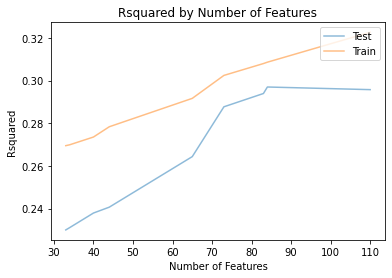

In [346]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25, 0]

r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X_price, y_price, cutoffs)

In [347]:
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2

0.29697424966673924
0.3085998646523481


In [348]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
72,property_type_Hostel,-721.457929,721.457929
73,property_type_Hotel,447.593676,447.593676
80,room_type_Hotel room,310.695888,310.695888
64,property_type_Boat,238.044652,238.044652
78,property_type_Townhouse,-182.406653,182.406653
77,property_type_Serviced apartment,-166.911170,166.911170
82,room_type_Shared room,150.482009,150.482009
43,neighbourhood_cleansed_Hillsboro Beach,146.082513,146.082513
8,bathrooms,139.100093,139.100093
68,property_type_Condominium,-135.649653,135.649653


### Question 2
What are the main features driving occupancy, measures with number of reviews? 

In [349]:
def get_review_data(df_review):

    # Drop rows with missing review values
    X = df_review.dropna(subset=['number_of_reviews'], axis=0)
    
    # Set y to number_of_reviews column
    y = df_review['number_of_reviews']
    
    # Set X to columns other than id and number_of_reviews
    X = df_review.drop(['id', 'number_of_reviews'], axis=1)
    
    # Fill review column nulls with 0
    num_cols = X.select_dtypes(include=['float', 'int']).columns
    for col in num_cols:
        X[col] = X[col].fillna(0)
        
    # Dummy the categorical variables
    cat_cols = X.select_dtypes(include=['object']).columns
    for col in  cat_cols:
        # for each cat add dummy var, drop original column
        X = pd.concat([X.drop(col, axis=1), pd.get_dummies(X[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)

    return X, y
    
#Use the function to create X and y
X_review, y_review = get_review_data(df_clean)

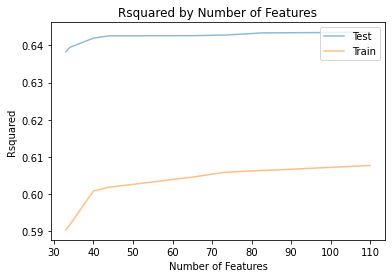

In [350]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25, 0]

r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X_review, y_review, cutoffs)

In [351]:
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2

0.6435668299231803
0.6076545099208543


In [352]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
91,property_type_Houseboat,-39.561938,39.561938
78,property_type_Casa particular (Cuba),32.981767,32.981767
70,property_type_Barn,31.763322,31.763322
109,bed_type_Real Bed,-29.027139,29.027139
108,bed_type_Pull-out Sofa,-25.385973,25.385973
35,reviews_per_month,22.067462,22.067462
80,property_type_Chalet,18.608144,18.608144
74,property_type_Bungalow,17.105313,17.105313
49,neighbourhood_cleansed_Lazy Lake,-14.517129,14.517129
83,property_type_Dome house,12.824187,12.824187


### Question 3
Is there a correlation between price and occupancy (measured by number of reviews)? 

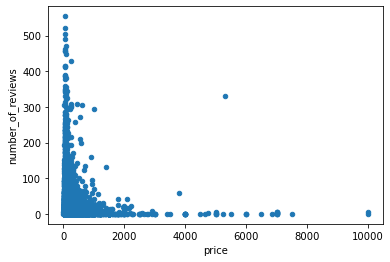

In [353]:
df_clean.plot(x='price', y='number_of_reviews', kind='scatter');

In [361]:
df_clean[['price','number_of_reviews']].corr(method='pearson')

,price,number_of_reviews
price,1.000000,-0.094471
number_of_reviews,-0.094471,1.000000


There is not a strong relationship between price and occupancy (number of reviews)